In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import nvgpu

nvgpu.gpu_info()

[{'index': '0',
  'type': 'NVIDIA A100-SXM4-40GB',
  'uuid': 'GPU-9100f485-776a-936e-fde1-1771ec395dd3',
  'mem_used': 1,
  'mem_total': 40960,
  'mem_used_percent': 0.00244140625},
 {'index': '1',
  'type': 'NVIDIA A100-SXM4-40GB',
  'uuid': 'GPU-4bb6a841-be72-1b05-7035-ecfff8b2f83b',
  'mem_used': 1,
  'mem_total': 40960,
  'mem_used_percent': 0.00244140625}]

In [ ]:
import functools


# we want to JIT the methods of a class on specific devices
# for convenience, we define a decorator that does this for us, this will use
# the device_id attribute of the class to determine the device to JIT on
def jit_with_device(method):
    """Decorator to Just-in-time compile a class method with a dynamic device.

    Decorates a method of a class with a dynamic device, allowing the method to be
    compiled with jax.jit for the specific device. This is needed since
    @functools.partial(jax.jit, device=jax.devices("gpu")[self._device_id]) is not
    allowed in a class definition.

    Parameters
    ----------
    method : callable
        Class method to decorate. If DESC is running on GPU, the class should have
        a device_id attribute.
    """

    @functools.wraps(method)
    def wrapper(self, *args, **kwargs):
        device = self._device

        # Compile the method with jax.jit for the specific device
        wrapped = jax.jit(method, device=device)
        return wrapped(self, *args, **kwargs)

    return wrapper

# `Optimizable` and `Objective` classes

These will be used during optimization problem. `Optimizable` stores the general info on the thing we try to optimize, and the `Objective` has the compute function that we use for the cost function.

In [ ]:
from jax.tree_util import register_pytree_node
import copy

DEVICE_TYPE = "gpu"


class Optimizable:
    def __init__(self, N, coefs):
        self.N = N
        self.coefs = coefs

    def N(self):
        return self.N

    def coefs(self):
        return self.coefs

    def copy(self):
        return copy.copy(self)

    def __repr__(self):
        return f"Optimizable(N={self.N}, coefs={self.coefs})"


def special_flatten_opt(obj):
    """Specifies a flattening recipe."""
    children = (obj.N, obj.coefs)
    aux_data = None
    return (children, aux_data)


def special_unflatten_opt(aux_data, children):
    """Specifies an unflattening recipe."""
    obj = object.__new__(Optimizable)
    obj.N = children[0]
    obj.coefs = children[1]
    return obj


class Objective:
    def __init__(self, opt, grid, target, device_id=0):
        self.opt = opt
        self.grid = grid
        self.target = target
        self.built = False
        self._device_id = device_id
        self._device = jax.devices(DEVICE_TYPE)[self._device_id]

    def build(self):
        # the transform matrix A such that A @ coefs gives the
        # values of the function at the grid points
        self.A = jnp.vstack([jnp.cos(i * self.grid) for i in range(self.opt.N)]).T
        self.built = True

    @jit_with_device
    def compute(self, coefs, A=None):
        if A is None:
            A = self.A
        vals = A @ coefs
        return vals

    @jit_with_device
    def compute_error(self, coefs, A=None):
        if A is None:
            A = self.A
        vals = A @ coefs
        return vals - self.target

    @jit_with_device
    def jac_error(self, coefs, A=None):
        if A is None:
            A = self.A
        return jax.jacfwd(self.compute_error)(coefs, A)

    @jit_with_device
    def jac(self, coefs, A=None):
        if A is None:
            A = self.A
        return jax.jacfwd(self.compute)(coefs, A)

To be able to use this classes in Jax transformed functions, we have to register them as proper pytrees. This means we have to define flattening and unflattening functions that converts the object to a tuple and from that tuple back to the object.

In [ ]:
def special_flatten_obj(obj):
    """Specifies a flattening recipe."""
    children = (obj.opt, obj.grid, obj.target, obj.A)
    aux_data = (obj.built, obj._device_id, obj._device)
    return (children, aux_data)


def special_unflatten_obj(aux_data, children):
    """Specifies an unflattening recipe."""
    obj = object.__new__(Objective)
    obj.opt = children[0]
    obj.grid = children[1]
    obj.target = children[2]
    obj.A = children[3]
    obj.built = aux_data[0]
    obj._device_id = aux_data[1]
    obj._device = aux_data[2]
    return obj


# Global registration
register_pytree_node(Optimizable, special_flatten_opt, special_unflatten_opt)
register_pytree_node(Objective, special_flatten_obj, special_unflatten_obj)

# Simple Optimization
We will use a very simple optimization problem in which we try to find the cosine fit to a function. `Optimizable` class has the max resolution and coefficients information. Coefficients are the things we change to get a proper fit.

Text(0.5, 1.0, 'Converged in 97 steps')

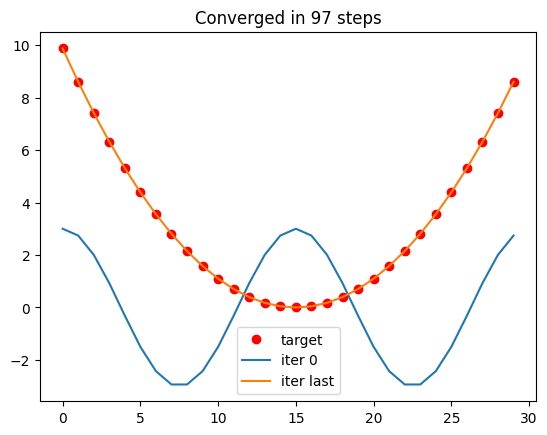

In [ ]:
N = 40
num_nodes = 30
coefs = np.zeros(N)
coefs[2] = 3
eq = Optimizable(N, coefs)
grid = jnp.linspace(-jnp.pi, jnp.pi, num_nodes, endpoint=False)
target = grid**2
obj = Objective(eq, grid, target)
obj.build()

plt.plot(obj.target, "or", label="target")
plt.plot(obj.compute(eq.coefs, obj.A), label=f"iter 0")
step = 0
while jnp.linalg.norm(obj.compute_error(eq.coefs, obj.A)) > 1e-3:
    J = obj.jac_error(eq.coefs, obj.A)
    f = obj.compute_error(eq.coefs, obj.A)
    eq.coefs = eq.coefs - 1e-1 * jnp.linalg.pinv(J) @ f
    step += 1
plt.plot(obj.compute(eq.coefs, obj.A), label=f"iter last")
plt.legend()
plt.title(f"Converged in {step} steps")

# Define `ObjectiveFunction` for multiple `Objective` cases
Above example had one `Objective`, but we might have multiple objective we try to minimize at the same time. For this, we will define `ObjectiveFunction` class that introduces the proper `compute` and `jac` definitions by concatenation of individual `Objective`s.

In [7]:
class ObjectiveFunction:
    def __init__(self, objectives):
        self.objectives = objectives
        self.built = False
        self.target = jnp.concatenate([obj.target for obj in self.objectives])

    def build(self):
        for obj in self.objectives:
            if not obj.built:
                obj.build()

        self.A = [obj.A for obj in self.objectives]
        self.built = True

    @jax.jit
    def compute(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]
        return jnp.concatenate(
            [
                obj.compute(coefi, Ai)
                for obj, coefi, Ai in zip(self.objectives, coefs, A)
            ]
        )

    @jax.jit
    def compute_error(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]
        return jnp.concatenate(
            [
                obj.compute_error(coefi, Ai)
                for obj, coefi, Ai in zip(self.objectives, coefs, A)
            ]
        )

    @jax.jit
    def jac_error(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]
        return jnp.vstack(
            [
                obj.jac_error(coefi, Ai)
                for obj, coefi, Ai in zip(self.objectives, coefs, A)
            ]
        )

    @jax.jit
    def jac(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]
        return jnp.vstack(
            [obj.jac(coefi, Ai) for obj, coefi, Ai in zip(self.objectives, coefs, A)]
        )

We have to register the new class as proper pytree.

In [8]:
def special_flatten_obj_fun(obj):
    """Specifies a flattening recipe."""
    children = (obj.objectives, obj.target, obj.A)
    aux_data = (obj.built,)
    return (children, aux_data)


def special_unflatten_obj_fun(aux_data, children):
    """Specifies an unflattening recipe."""
    obj = object.__new__(ObjectiveFunction)
    obj.objectives = children[0]
    obj.target = children[1]
    obj.A = children[2]
    obj.built = aux_data[0]
    return obj


register_pytree_node(
    ObjectiveFunction, special_flatten_obj_fun, special_unflatten_obj_fun
)

# Verify both work the same
Now, we will create an `ObjectiveFunction` by dividing the grid into multiple parts. In reality, we might have different `Objective` classes, but here we only care about dividing the `Objective` into multiple devices and combining the results by `ObjectiveFunction`.

In [15]:
N = 40
num_nodes = 15
coefs = np.zeros(N)
coefs[2] = 3
eq = Optimizable(N, coefs)
grid1 = jnp.linspace(-jnp.pi, 0, num_nodes, endpoint=False)
grid2 = jnp.linspace(0, jnp.pi, num_nodes, endpoint=False)
grid3 = jnp.concatenate([grid1, grid2])
target1 = grid1**2
target2 = grid2**2
target3 = grid3**2

obj1 = Objective(eq, grid1, target1)
obj2 = Objective(eq, grid2, target2)
obj_fun = ObjectiveFunction([obj1, obj2])
obj_fun.build()

eq1 = eq.copy()
obj3 = Objective(eq1, grid3, target3)
obj3.build()

Results using `ObjectiveFunction` with 2 `Objective`s inside,

Text(0.5, 1.0, 'Converged in 97 steps')

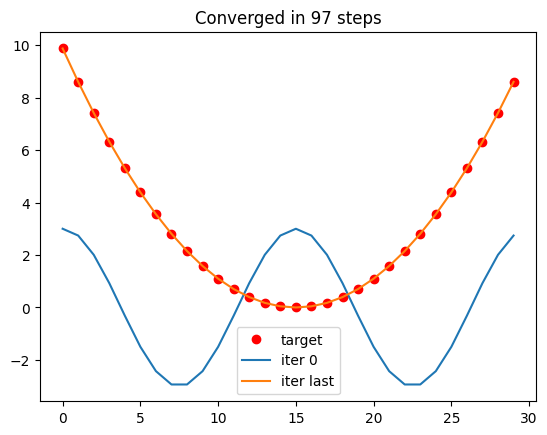

In [ ]:
plt.plot(obj_fun.target, "or", label="target")
plt.plot(obj_fun.compute(), label=f"iter 0")
step = 0
while jnp.linalg.norm(obj_fun.compute_error()) > 1e-3:
    J = obj_fun.jac_error()
    f = obj_fun.compute_error()
    eq.coefs = eq.coefs - 1e-1 * jnp.linalg.pinv(J) @ f
    step += 1
plt.plot(obj_fun.compute(), label=f"iter last")
plt.legend()
plt.title(f"Converged in {step} steps")

Results with single big `Objective`,

Text(0.5, 1.0, 'Converged in 97 steps')

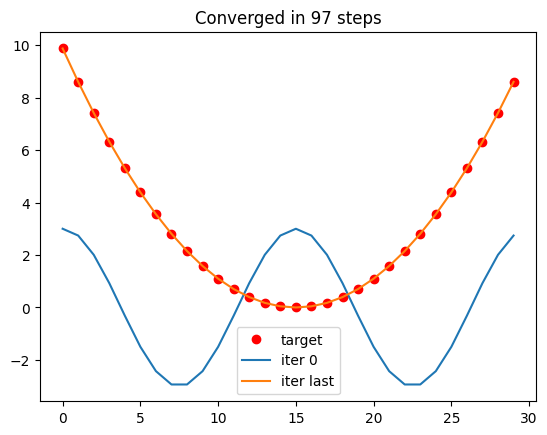

In [ ]:
plt.plot(obj3.target, "or", label="target")
plt.plot(obj3.compute(eq1.coefs, obj3.A), label=f"iter 0")
step = 0
while jnp.linalg.norm(obj3.compute_error(eq1.coefs, obj3.A)) > 1e-3:
    J = obj3.jac_error(eq1.coefs, obj3.A)
    f = obj3.compute_error(eq1.coefs, obj3.A)
    eq1.coefs = eq1.coefs - 1e-1 * jnp.linalg.pinv(J) @ f
    step += 1
plt.plot(obj3.compute(eq1.coefs, obj3.A), label=f"iter last")
plt.legend()
plt.title(f"Converged in {step} steps")

In [22]:
np.allclose(eq.coefs, eq1.coefs)

True

# Multiple GPU
Our main goal by dividing the single `Objective` into multiple ones and then merge them by `ObjectiveFunction` is to execute the computation of each objective on different device to reduce the memory!

Normal `jnp.concatenate` doesn't work if each array lives on different GPU. That is why we will create a new helper function to achieve this. Unfortunately, the resultant array will live on the first GPU.

In [ ]:
def pconcat(arrays, mode="concat"):
    """Concatenate arrays that live on different devices.

    Parameters
    ----------
    arrays : list of jnp.ndarray
        Arrays to concatenate.
    mode : str
        "concat:, "hstack" or "vstack. Default is "concat"

    Returns
    -------
    out : jnp.ndarray
        Concatenated array that lives on CPU.
    """
    if DEVICE_TYPE == "gpu":
        devices = nvgpu.gpu_info()
        mem_avail = devices[0]["mem_total"] - devices[0]["mem_used"]
        # we will use either CPU or GPU[0] for the matrix decompositions, so the
        # array of float64 should fit into single device
        size = jnp.array([x.size for x in arrays])
        size = jnp.sum(size)
        if size * 8 / (1024**3) > mem_avail:
            device = jax.devices("cpu")[0]
        else:
            device = jax.devices("gpu")[0]
    else:
        device = jax.devices("cpu")[0]

    if mode == "concat":
        out = jnp.concatenate([jax.device_put(x, device=device) for x in arrays])
    elif mode == "hstack":
        out = jnp.hstack([jax.device_put(x, device=device) for x in arrays])
    elif mode == "vstack":
        out = jnp.vstack([jax.device_put(x, device=device) for x in arrays])
    return out

In [ ]:
class ObjectiveFunctionMultiGpu:
    def __init__(self, objectives):
        self.objectives = objectives
        self.num_device = len(objectives)
        self.built = False
        targets = [obj.target for obj in self.objectives]
        self.target = pconcat(targets)

    def build(self):
        for obj in self.objectives:
            if not obj.built:
                obj.build()

        self.A = [obj.A for obj in self.objectives]
        self.built = True

    def compute(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]

        fs = [
            obj.compute(jax.device_put(coefi, device=obj._device), Ai)
            for obj, coefi, Ai in zip(self.objectives, coefs, A)
        ]
        return pconcat(fs)

    def compute_error(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]

        fs = [
            obj.compute_error(jax.device_put(coefi, device=obj._device), Ai)
            for obj, coefi, Ai in zip(self.objectives, coefs, A)
        ]
        return pconcat(fs)

    def jac_error(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]

        # we need to move coefi to corresponding GPU because jit compiled
        # functions only accept data from same device. Since, we try to use
        # same obj.opt for all, and we store that on first GPU, hence coefs
        # is a list of coefficients that are on first GPU. We could have
        # Objectives without opt attribute but this a design choice we would
        # like to keep
        fs = [
            obj.jac_error(jax.device_put(coefi, device=obj._device), Ai)
            for obj, coefi, Ai in zip(self.objectives, coefs, A)
        ]
        return pconcat(fs)

    def jac(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]

        fs = [
            obj.jac(jax.device_put(coefi, device=obj._device), Ai)
            for obj, coefi, Ai in zip(self.objectives, coefs, A)
        ]
        return pconcat(fs)

    def _flatten(obj):
        """Specifies a flattening recipe."""
        children = (obj.objectives, obj.target, obj.A)
        aux_data = (obj.built,)
        return (children, aux_data)

    @classmethod
    def _unflatten(cls, aux_data, children):
        """Specifies an unflattening recipe."""
        cls.objectives = children[0]
        cls.target = children[1]
        cls.A = children[2]
        cls.built = aux_data[0]
        return cls


register_pytree_node(
    ObjectiveFunctionMultiGpu,
    ObjectiveFunctionMultiGpu._flatten,
    ObjectiveFunctionMultiGpu._unflatten,
)

In [ ]:
N = 40
num_nodes = 15
coefs = np.zeros(N)
coefs[2] = 3
eq = Optimizable(N, coefs)
grid1 = jnp.linspace(-jnp.pi, 0, num_nodes, endpoint=False)
grid2 = jnp.linspace(0, jnp.pi, num_nodes, endpoint=False)
grid3 = jnp.concatenate([grid1, grid2])
target1 = grid1**2
target2 = grid2**2
target3 = grid3**2

obj1 = Objective(eq, grid1, target1, device_id=0)
obj2 = Objective(eq, grid2, target2, device_id=1)
obj1.build()
obj2.build()

# we will put different objectives to different devices
obj1 = jax.device_put(obj1, obj1._device)
obj2 = jax.device_put(obj2, obj2._device)
# if we don't assign the eq again, there will be no connection
# between obj.opt.coefs. Since they are supposed to be the same optimizable,
# they need to have same pointers (jax.device_put creates a copy which has
# different memory location)
obj1.opt = eq
obj2.opt = eq

objp_fun = ObjectiveFunctionMultiGpu([obj1, obj2])
objp_fun.build()

Text(0.5, 1.0, 'Converged in 97 steps')

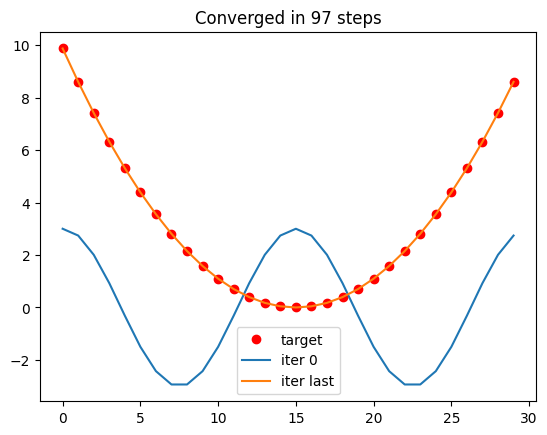

In [ ]:
objective = objp_fun
plt.plot(objective.target, "or", label="target")
plt.plot(objective.compute(), label=f"iter 0")
step = 0
while jnp.linalg.norm(objective.compute_error()) > 1e-3:
    J = objective.jac_error()
    f = objective.compute_error()
    eq.coefs = eq.coefs - 1e-1 * jnp.linalg.pinv(J) @ f
    step += 1
plt.plot(objective.compute(), label=f"iter last")
plt.legend()
plt.title(f"Converged in {step} steps")

# Multiple GPUs and Parallel

Now, let's use `MPI`

In [ ]:
class ObjectiveFunctionMPI:
    def __init__(self, objectives, mpi):
        self.objectives = objectives
        self.num_device = len(objectives)
        self.built = False
        targets = [obj.target for obj in self.objectives]
        self.target = pconcat(targets)
        self.mpi = mpi
        self.comm = self.mpi.COMM_WORLD
        self.rank = self.comm.Get_rank()
        self.size = self.comm.Get_size()
        # we will run each objective on different rank
        assert self.size == len(self.objectives)

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        pass

    def build(self):
        for obj in self.objectives:
            if not obj.built:
                obj.build()

        self.A = [obj.A for obj in self.objectives]
        self.built = True

    def compute(self, coefs=None, A=None):
        if self.rank == 0:
            if A is None:
                A = self.A
            if coefs is None:
                coefs = [obj.opt.coefs for obj in self.objectives]

            fs = [
                obj.compute(jax.device_put(coefi, device=obj._device), Ai)
                for obj, coefi, Ai in zip(self.objectives, coefs, A)
            ]
            return pconcat(fs)
        else:
            return None

    def compute_error(self, coefs=None, A=None):
        if self.rank == 0:
            if A is None:
                A = self.A
            if coefs is None:
                coefs = [obj.opt.coefs for obj in self.objectives]

            fs = [
                obj.compute_error(jax.device_put(coefi, device=obj._device), Ai)
                for obj, coefi, Ai in zip(self.objectives, coefs, A)
            ]
            return pconcat(fs)
        else:
            return None

    def jac_error(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]

        obj = self.objectives[self.rank]
        coefi = coefs[self.rank]
        Ai = A[self.rank]
        f = obj.jac_error(jax.device_put(coefi, device=obj._device), Ai)
        f = np.asarray(f)
        if self.rank == 0:
            fs = self.comm.gatherv(f, root=0)
        return pconcat(fs)

    def jac(self, coefs=None, A=None):
        if A is None:
            A = self.A
        if coefs is None:
            coefs = [obj.opt.coefs for obj in self.objectives]

        obj = self.objectives[self.rank]
        coefi = coefs[self.rank]
        Ai = A[self.rank]
        f = obj.jac(jax.device_put(coefi, device=obj._device), Ai)
        f = np.asarray(f)
        if self.rank == 0:
            fs = self.comm.gatherv(f, root=0)
        return pconcat(fs)

    def _flatten(obj):
        """Specifies a flattening recipe."""
        children = (obj.objectives, obj.target, obj.A)
        aux_data = (obj.built,)
        return (children, aux_data)

    @classmethod
    def _unflatten(cls, aux_data, children):
        """Specifies an unflattening recipe."""
        cls.objectives = children[0]
        cls.target = children[1]
        cls.A = children[2]
        cls.built = aux_data[0]
        return cls


register_pytree_node(
    ObjectiveFunctionMPI,
    ObjectiveFunctionMPI._flatten,
    ObjectiveFunctionMPI._unflatten,
)

In [ ]:
N = 40
num_nodes = 15
coefs = np.zeros(N)
coefs[2] = 3
eq = Optimizable(N, coefs)
grid1 = jnp.linspace(-jnp.pi, 0, num_nodes, endpoint=False)
grid2 = jnp.linspace(0, jnp.pi, num_nodes, endpoint=False)
grid3 = jnp.concatenate([grid1, grid2])
target1 = grid1**2
target2 = grid2**2
target3 = grid3**2

obj1 = Objective(eq, grid1, target1, device_id=0)
obj2 = Objective(eq, grid2, target2, device_id=1)
obj1.build()
obj2.build()

# we will put different objectives to different devices
obj1 = jax.device_put(obj1, obj1._device)
obj2 = jax.device_put(obj2, obj2._device)
# if we don't assign the eq again, there will be no connection
# between obj.opt.coefs. Since they are supposed to be the same optimizable,
# they need to have same pointers (jax.device_put creates a copy which has
# different memory location)
obj1.opt = eq
obj2.opt = eq

In [ ]:
from mpi4py import MPI

with ObjectiveFunctionMPI([obj1, obj2], mpi=MPI) as objective:
    objp_fun.build()
    if objective.rank == 0:
        plt.plot(objective.target, "or", label="target")
        plt.plot(objective.compute(), label=f"iter 0")
        step = 0
        while jnp.linalg.norm(objective.compute_error()) > 1e-3:
            J = objective.jac_error()
            f = objective.compute_error()
            eq.coefs = eq.coefs - 1e-1 * jnp.linalg.pinv(J) @ f
            step += 1
        plt.plot(objective.compute(), label=f"iter last")
        plt.legend()
        plt.title(f"Converged in {step} steps")